In [1]:
# if jupyterlab:
%matplotlib widget
# if jupyter notebook:
# %matplotlib notebook

import os
import torch
import twixtools
import numpy as np
import matplotlib.pyplot as plt
from recoMRD_B1BSS import recoMRD_B1BSS
from pytools import plot, dico_tools

plt.rcParams['svg.fonttype'] = 'none' # to embed fonts in SVG output

torch.set_printoptions(linewidth=380)

def CoV(sig, sig2=None, axis=-1, sd=False):
    cv = np.std(sig, axis=axis)
    if sig2 is not None:
        sig = np.concatenate((sig, sig2), axis=axis)
    if sd==False:
        cv =  100 * cv / np.mean(sig, axis=axis)
    return cv
    
folder = '/DATA2/rawdata/RFPA_Drift/BSS/test/'
file_corr0 = 'meas_MID00499_FID66382_aa_bss_TR25ms_Dur8ms_FA400_Rep10_Corr0_Tra'
file_corr1 = 'meas_MID00500_FID66383_aa_bss_TR25ms_Dur8ms_FA400_Rep10_Corr1_Tra'

filename = os.path.join(folder, file_corr0 + '.mrd')
mrd_corr0 = recoMRD_B1BSS(filename)

filename = os.path.join(folder, file_corr1 + '.mrd')
mrd_corr1= recoMRD_B1BSS(filename)

Number of reference scans: 0
Number of image     scans: 960
k-space size in protocol: 96 x 48 x 1
image   size in protocol: 48 x 48 x 1
Existing scans: nav, noise, feedback, image_scan.
Fully sampled array size=[32, 96, 48, 1, 1, 1, 10, 2, 1, 1, 1]


Filling image_scan, size=[32, 96, 48, 1, 1, 1, 10, 2, 1, 1, 1]: 100%|██████████| 960/960 [00:00<00:00, 20035.69it/s]


BSS Pulse Integral [V*Sec]:     0.545524
BSS Pulse Integral Normalized:  5997.313
BSS Pulse Power Normalized:     5599.991
BSS Pulse Duration [us]:        8000
BSS Pulse Off Resonance [Hz]:   5000
BSS Pulse Voltage [V]:          90.961
Ref Pulse Voltage [V]:          245.486
Removing oversampling...
Done!


Fourier transform: 100%|██████████| 32/32 [00:00<00:00, 1309.61it/s]

KBS = 6378625054.333128 rad/T²


Number of reference scans: 0
Number of image     scans: 960
k-space size in protocol: 96 x 48 x 1
image   size in protocol: 48 x 48 x 1
Existing scans: nav, noise, feedback, image_scan.
Fully sampled array size=[32, 96, 48, 1, 1, 1, 10, 2, 1, 1, 1]


Filling image_scan, size=[32, 96, 48, 1, 1, 1, 10, 2, 1, 1, 1]: 100%|██████████| 960/960 [00:00<00:00, 17728.65it/s]


BSS Pulse Integral [V*Sec]:     0.545524
BSS Pulse Integral Normalized:  5997.313
BSS Pulse Power Normalized:     5599.991
BSS Pulse Duration [us]:        8000
BSS Pulse Off Resonance [Hz]:   5000
BSS Pulse Voltage [V]:          90.961
Ref Pulse Voltage [V]:          245.486
Removing oversampling...
Done!


Fourier transform: 100%|██████████| 32/32 [00:00<00:00, 1890.52it/s]

KBS = 6378625054.333128 rad/T²


/kyb/agks/aaghaeifar/.local/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


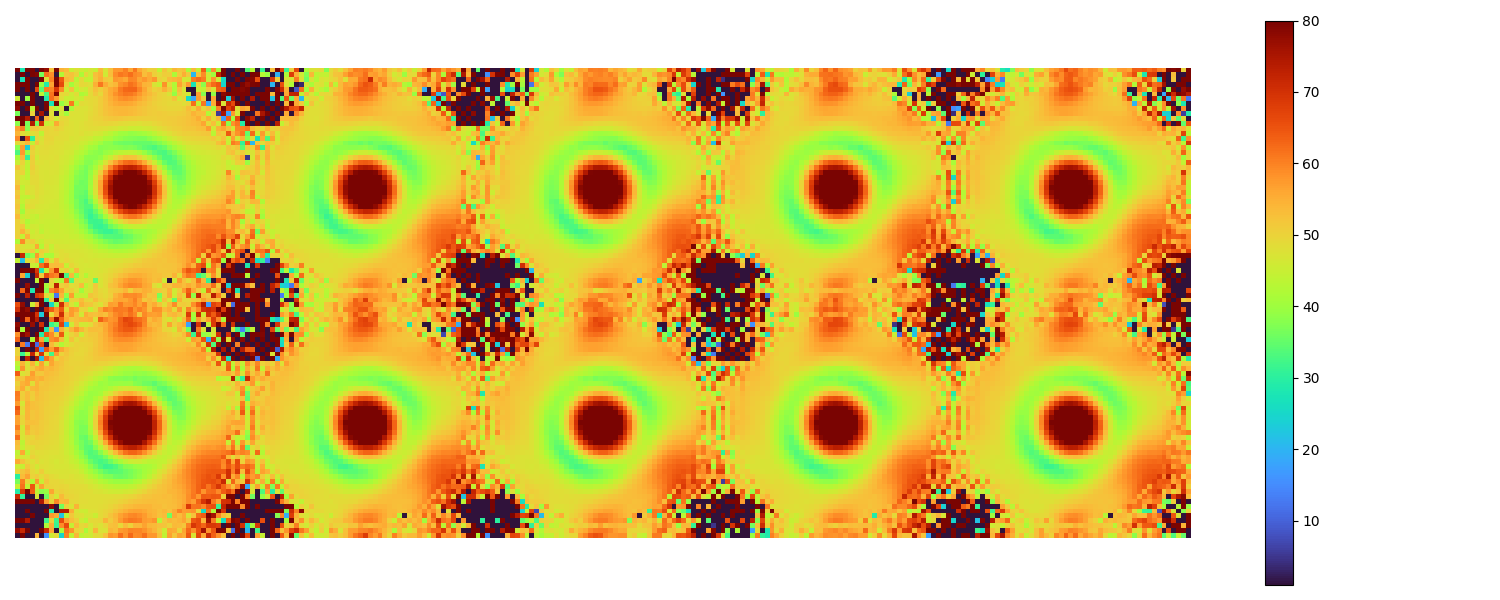

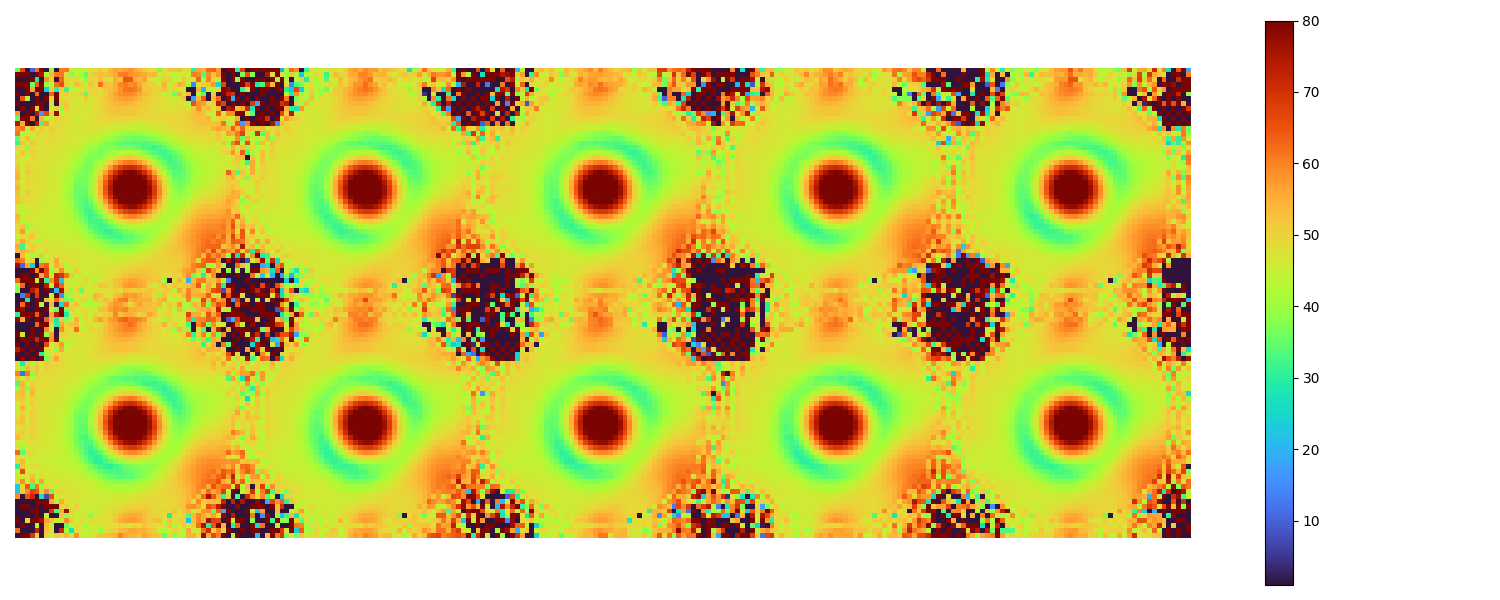

In [2]:
if mrd_corr0.dim_info['rep']['len'] == 1:
    plot.plot3D( mrd_corr0.img_b1nTv , clim=[1, 80])
else:
    plot.plot_mosaic(mrd_corr0.img_b1nTv.cpu().detach().numpy(), grid_shape=[2, 5], clim=[1, 80])
    plot.plot_mosaic(mrd_corr1.img_b1nTv.cpu().detach().numpy(), grid_shape=[2, 5], clim=[1, 80])

    

(48, 48, 10)
(48, 48, 1)
(48, 48, 1)


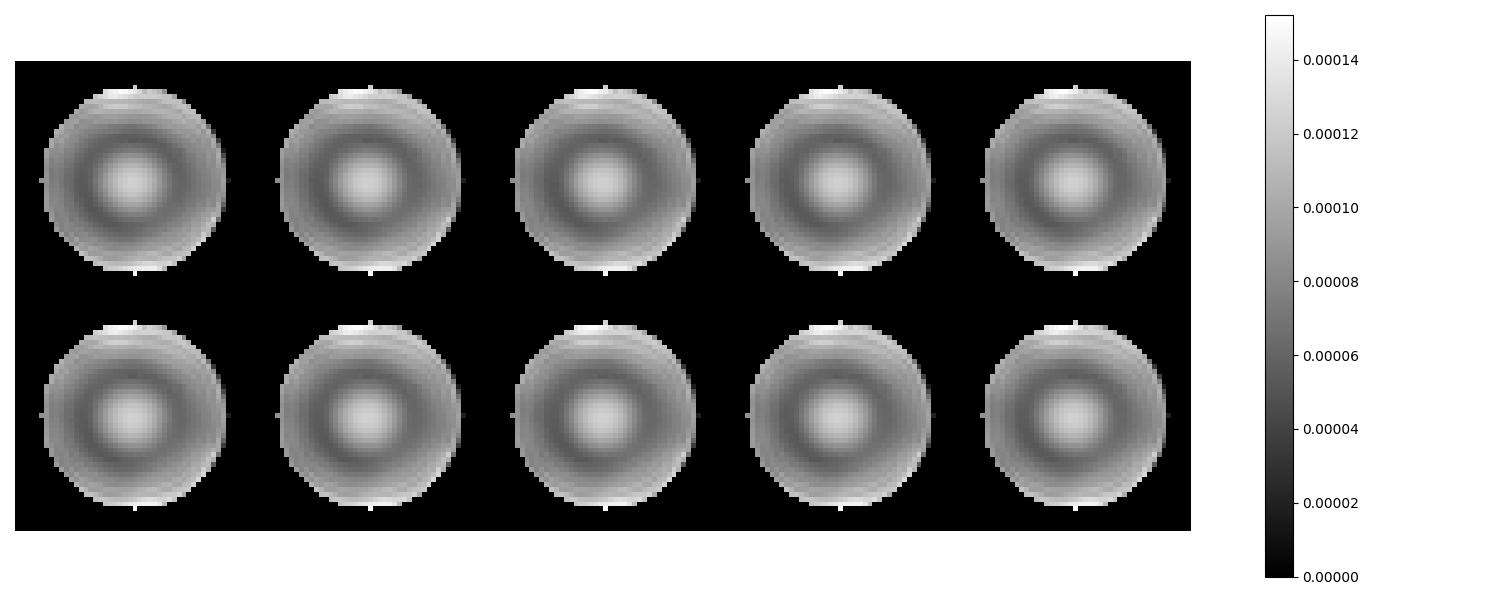

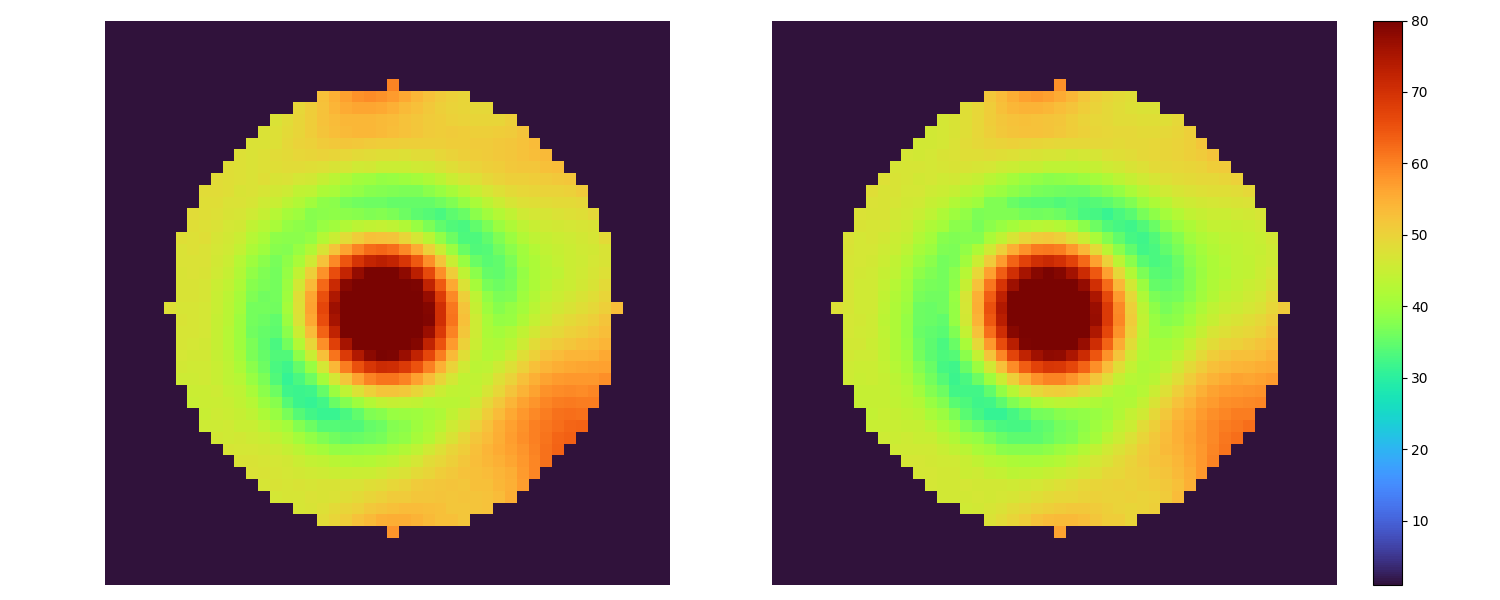

In [3]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

if mrd_corr0.dim_info['rep']['len'] != 1:
    temp1 = mrd_corr0.img_mag.index_select(mrd_corr0.dim_info['pe2']['ind'], torch.Tensor([0]).int())
    temp1 = temp1.index_select(mrd_corr0.dim_info['set']['ind'], torch.Tensor([0]).int())
    temp1 = temp1.squeeze().cpu().detach().numpy()
    # plot.plot_mosaic(temp1, cmap='gray')
    mask = create_circular_mask(temp1.shape[0], temp1.shape[1], center=[temp1.shape[0]//2, temp1.shape[1]//2], radius=19)
    mask = mask[...,np.newaxis]
    print(temp1.shape)
    print(mask.shape)
    # mask = np.repeat(mask[...,np.newaxis], temp1.shape[2], axis=2)
    print(mask.shape)
    temp1 = temp1 * mask
    plot.plot_mosaic(temp1, grid_shape = [2, 5], cmap='gray')

    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    plt.imshow(mrd_corr0.img_b1nTv.cpu().squeeze().detach().numpy()[...,[0]] * mask, cmap='turbo', interpolation='nearest', clim=[1, 80])
    plt.axis('off')
    plt.subplot(122)    
    plt.imshow(mrd_corr1.img_b1nTv.cpu().squeeze().detach().numpy()[...,[0]] * mask, cmap='turbo', interpolation='nearest', clim=[1, 80])
    plt.axis('off')
    plt.colorbar()
    plt.tight_layout() 
    plt.savefig('/DATA/aaghaeifar/Nextcloud/MyPresentations/ismrm2024/figures/B1.svg', format='svg', dpi=1200)

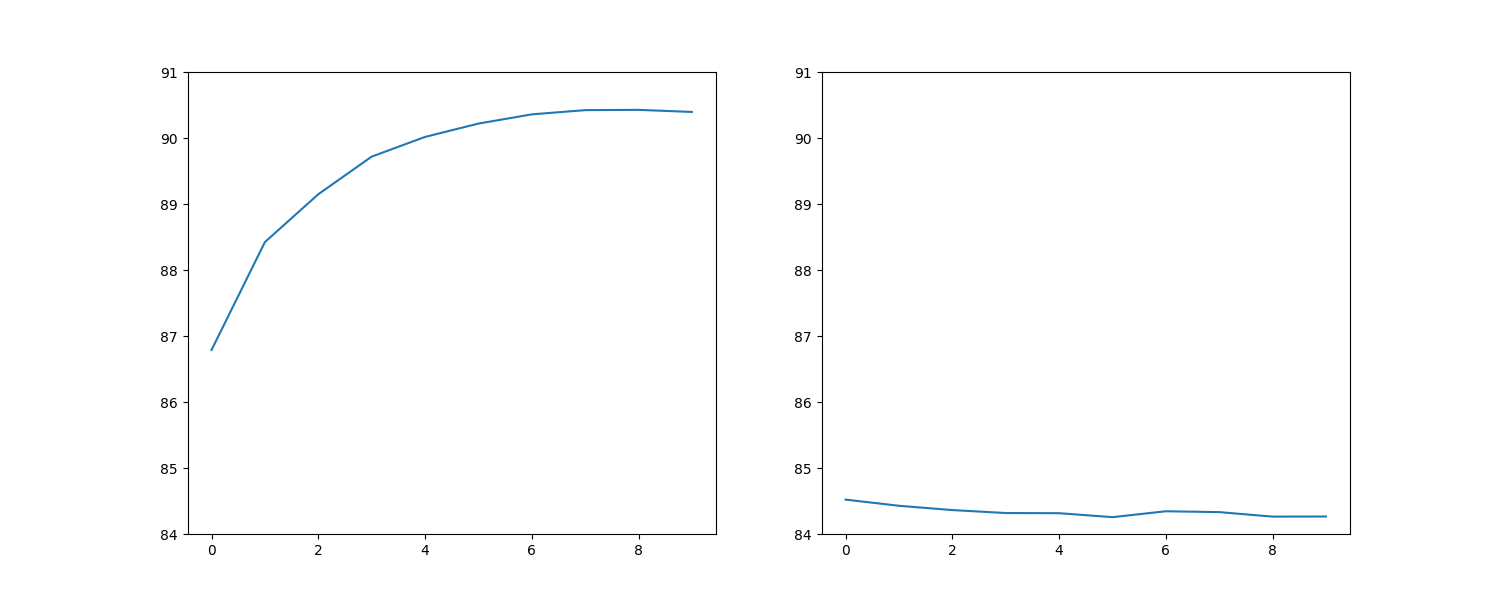

In [4]:
temp1 = mrd_corr0.img_b1nTv.cpu().squeeze().detach().numpy()
mask_c = create_circular_mask(temp1.shape[0], temp1.shape[1], center=[temp1.shape[0]//2-1, temp1.shape[1]//2], radius=4)
mask_c = mask_c[...,np.newaxis]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

temp1 = mrd_corr0.img_b1nTv.cpu().squeeze().detach().numpy() * mask_c
temp1 = temp1.sum(axis=(0,1)) / mask_c.sum(axis=(0,1))
ax[0].plot(temp1)
ax[0].set_ylim([84, 91]) # phantom

temp1 = mrd_corr1.img_b1nTv.cpu().squeeze().detach().numpy() * mask_c
temp1 = temp1.sum(axis=(0,1)) / mask_c.sum(axis=(0,1))
ax[1].plot(temp1)
ax[1].set_ylim([84, 91]) # phantom

plt.savefig('/DATA/aaghaeifar/Nextcloud/MyPresentations/ismrm2024/figures/B1_drift.svg', format='svg', dpi=1200)

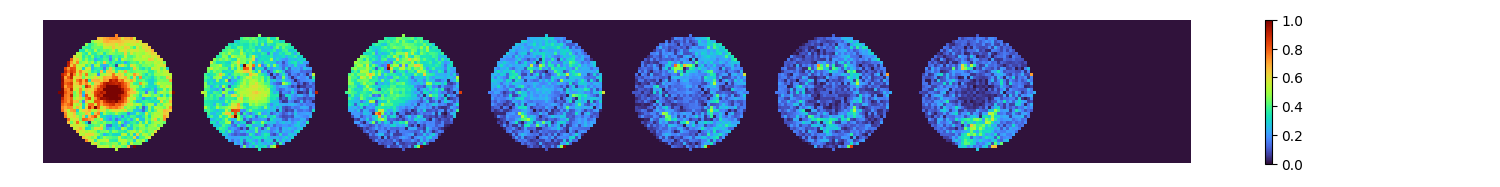

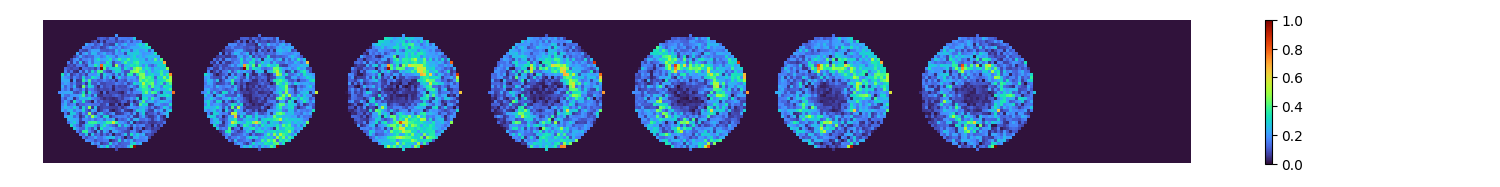

In [7]:
if mrd_corr0.dim_info['rep']['len'] == 1:
    plot.plot3D( mrd_corr0.img_b1nTv , clim=[1, 80])
else:
    l_cov = 3
    temp1 = mrd_corr0.img_b1nTv.index_select(mrd_corr0.dim_info['pe2']['ind'], torch.Tensor([0]).int())
    temp1 = temp1.squeeze().cpu().detach().numpy()
    temp2 = [CoV(temp1[...,i:i+l_cov], axis=2, sd=True) for i in range(mrd_corr0.dim_info['rep']['len']-l_cov)]
    temp2 = np.dstack(temp2) * mask
    plot.plot_mosaic(temp2[...,:16], grid_shape = [1, 8], clim=[0, 1])

    # plt.savefig('/DATA/aaghaeifar/Nextcloud/MyPresentations/ismrm2024/figures/B1_drift_std1.svg', format='svg', dpi=1200)

    temp1 = mrd_corr1.img_b1nTv.index_select(mrd_corr1.dim_info['pe2']['ind'], torch.Tensor([0]).int())
    temp1 = temp1.squeeze().cpu().detach().numpy()
    temp2 = [CoV(temp1[...,i:i+l_cov], axis=2, sd=True) for i in range(mrd_corr1.dim_info['rep']['len']-l_cov)]
    temp2 = np.dstack(temp2) * mask
    plot.plot_mosaic(temp2[...,:16], grid_shape = [1, 8], clim=[0, 1])

    # plt.savefig('/DATA/aaghaeifar/Nextcloud/MyPresentations/ismrm2024/figures/B1_drift_std2.svg', format='svg', dpi=1200)

In [ ]:

twixObj = twixtools.read_twix(os.path.join(folder, file_corr0 + '.dat'))
frwd    = dico_tools.read_dico_memOpt(twixObj)[0]

fig, ax = plt.subplots(2, 1, figsize=(15, 6))
ax[0].plot(frwd[0].T)
ax[1].plot(frwd[1].T)

twixObj = twixtools.read_twix(os.path.join(folder, file_corr1 + '.dat'))
frwd    = dico_tools.read_dico_memOpt(twixObj)[0]

fig, ax = plt.subplots(2, 1, figsize=(15, 6))
ax[0].plot(frwd[0].T)
ax[1].plot(frwd[1].T)

# fa_map = mrd.img_fa.index_select(mrd.dim_info['pe2']['ind'], torch.Tensor([32]).int())
# plot_mosaic(fa_map.abs().numpy(), grid_shape=(2, 8))
# plot_mosaic(fa_map.angle().numpy(), grid_shape=(2, 8))
# mrd.make_nifti(mrd.img_b1nTv, '/DATA2/rawdata/RFPA_Drift/BSS/bss.nii')

In [8]:
import os
import twixtools
import numpy as np
import matplotlib.pyplot as plt
from pytools import plot, dico_tools

folder = '/DATA2/rawdata/RFPA_Drift/BSS/test/'
files  = ['meas_MID00503_FID66386_aa_bss_TR40ms_Dur8ms_FA600_Rep10_Corr0_Tra',
          'meas_MID00504_FID66387_aa_bss_TR40ms_Dur8ms_FA600_Rep10_Corr1_Tra',
          'meas_MID00492_FID66375_aa_bss_TR40ms_Dur8ms_FA400_Rep10_Corr0_Tra',
          'meas_MID00493_FID66376_aa_bss_TR40ms_Dur8ms_FA400_Rep10_Corr1_Tra',
          'meas_MID00488_FID66371_aa_bss_TR40ms_Dur8ms_FA250_Rep10_Corr0_Tra',
          'meas_MID00489_FID66372_aa_bss_TR40ms_Dur8ms_FA250_Rep10_Corr1_Tra',
          'meas_MID00501_FID66384_aa_bss_TR40ms_Dur5ms_FA400_Rep10_Corr0_Tra',
          'meas_MID00502_FID66385_aa_bss_TR40ms_Dur5ms_FA400_Rep10_Corr1_Tra',
          'meas_MID00496_FID66379_aa_bss_TR40ms_Dur5ms_FA250_Rep10_Corr0_Tra',
          'meas_MID00497_FID66380_aa_bss_TR40ms_Dur5ms_FA250_Rep10_Corr1_Tra',
          'meas_MID00484_FID66367_aa_bss_TR25ms_Dur8ms_FA250_Rep15_Corr0_Tra',
          'meas_MID00486_FID66369_aa_bss_TR25ms_Dur8ms_FA250_Rep10_Corr1_Tra',          
          'meas_MID00499_FID66382_aa_bss_TR25ms_Dur8ms_FA400_Rep10_Corr0_Tra',
          'meas_MID00500_FID66383_aa_bss_TR25ms_Dur8ms_FA400_Rep10_Corr1_Tra'          
          ]

twixObj = [twixtools.read_twix(os.path.join(folder, f + '.dat')) for f in files]
frwd    = [dico_tools.read_dico_memOpt(twixobj)[0] for twixobj in twixObj]

Software version: VD/VE (!?)

Scan  0


  0%|          | 0.00/2.09G [00:00<?, ?B/s]

Software version: VD/VE (!?)

Scan  0


  0%|          | 0.00/2.09G [00:00<?, ?B/s]

Software version: VD/VE (!?)

Scan  0


  0%|          | 0.00/2.09G [00:00<?, ?B/s]

Software version: VD/VE (!?)

Scan  0


  0%|          | 0.00/2.09G [00:00<?, ?B/s]

Software version: VD/VE (!?)

Scan  0


  0%|          | 0.00/2.09G [00:00<?, ?B/s]

Software version: VD/VE (!?)

Scan  0


  0%|          | 0.00/2.09G [00:00<?, ?B/s]

Software version: VD/VE (!?)

Scan  0


  0%|          | 0.00/1.40G [00:00<?, ?B/s]

Software version: VD/VE (!?)

Scan  0


  0%|          | 0.00/1.40G [00:00<?, ?B/s]

Software version: VD/VE (!?)

Scan  0


  0%|          | 0.00/1.40G [00:00<?, ?B/s]

Software version: VD/VE (!?)

Scan  0


  0%|          | 0.00/1.40G [00:00<?, ?B/s]

Software version: VD/VE (!?)

Scan  0


  0%|          | 0.00/2.09G [00:00<?, ?B/s]

Software version: VD/VE (!?)

Scan  0


  0%|          | 0.00/2.09G [00:00<?, ?B/s]

Software version: VD/VE (!?)

Scan  0


  0%|          | 0.00/2.09G [00:00<?, ?B/s]

Software version: VD/VE (!?)

Scan  0


  0%|          | 0.00/2.09G [00:00<?, ?B/s]

Reading DICO:   0%|          | 0/8640 [00:00<?, ?it/s]

Reading DICO:   0%|          | 0/8640 [00:00<?, ?it/s]

Reading DICO:   0%|          | 0/8640 [00:00<?, ?it/s]

Reading DICO:   0%|          | 0/8640 [00:00<?, ?it/s]

Reading DICO:   0%|          | 0/8640 [00:00<?, ?it/s]

Reading DICO:   0%|          | 0/8640 [00:00<?, ?it/s]

Reading DICO:   0%|          | 0/5760 [00:00<?, ?it/s]

Reading DICO:   0%|          | 0/5760 [00:00<?, ?it/s]

Reading DICO:   0%|          | 0/5760 [00:00<?, ?it/s]

Reading DICO:   0%|          | 0/5760 [00:00<?, ?it/s]

Reading DICO:   0%|          | 0/8640 [00:00<?, ?it/s]

Reading DICO:   0%|          | 0/8640 [00:00<?, ?it/s]

Reading DICO:   0%|          | 0/8640 [00:00<?, ?it/s]

Reading DICO:   0%|          | 0/8640 [00:00<?, ?it/s]

14
(16, 960)
Max drift: [ 4.452777   4.6842694  4.814124   4.908514   4.331112   4.875016
  4.3869257  4.295945   9.925079   9.653986   8.93743    9.983599
  8.456099   8.38418    9.779167  11.25127  ]
Max drift: [0.68974495 0.70340633 0.70456266 0.6050348  0.6741762  0.7756829
 0.7534027  0.6162524  1.2556076  1.2484193  0.9198785  1.3539314
 0.9447336  0.93296766 1.4399886  1.3199806 ]
Max drift: [ 4.1494966  4.356587   4.421246   4.6315074  3.993702   4.5214653
  4.1894317  3.9725661  9.296179   8.228504   8.015013   9.700668
  7.94127    7.834816   8.582199  11.041248 ]
Max drift: [0.59410334 0.6025672  0.58112144 0.54177046 0.46880245 0.59109926
 0.6817579  0.5097747  0.65147877 0.7229686  0.6348133  0.8077383
 0.6394863  0.668633   0.6013036  0.64611435]
Max drift: [4.089117  4.2877674 4.253161  4.533994  3.861034  4.3569446 4.0322065
 3.8883448 8.785021  8.070016  7.567036  8.856094  7.6403975 7.9958677
 7.6099634 9.45698  ]
Max drift: [0.42283535 0.4531026  0.3737688  0.4564047

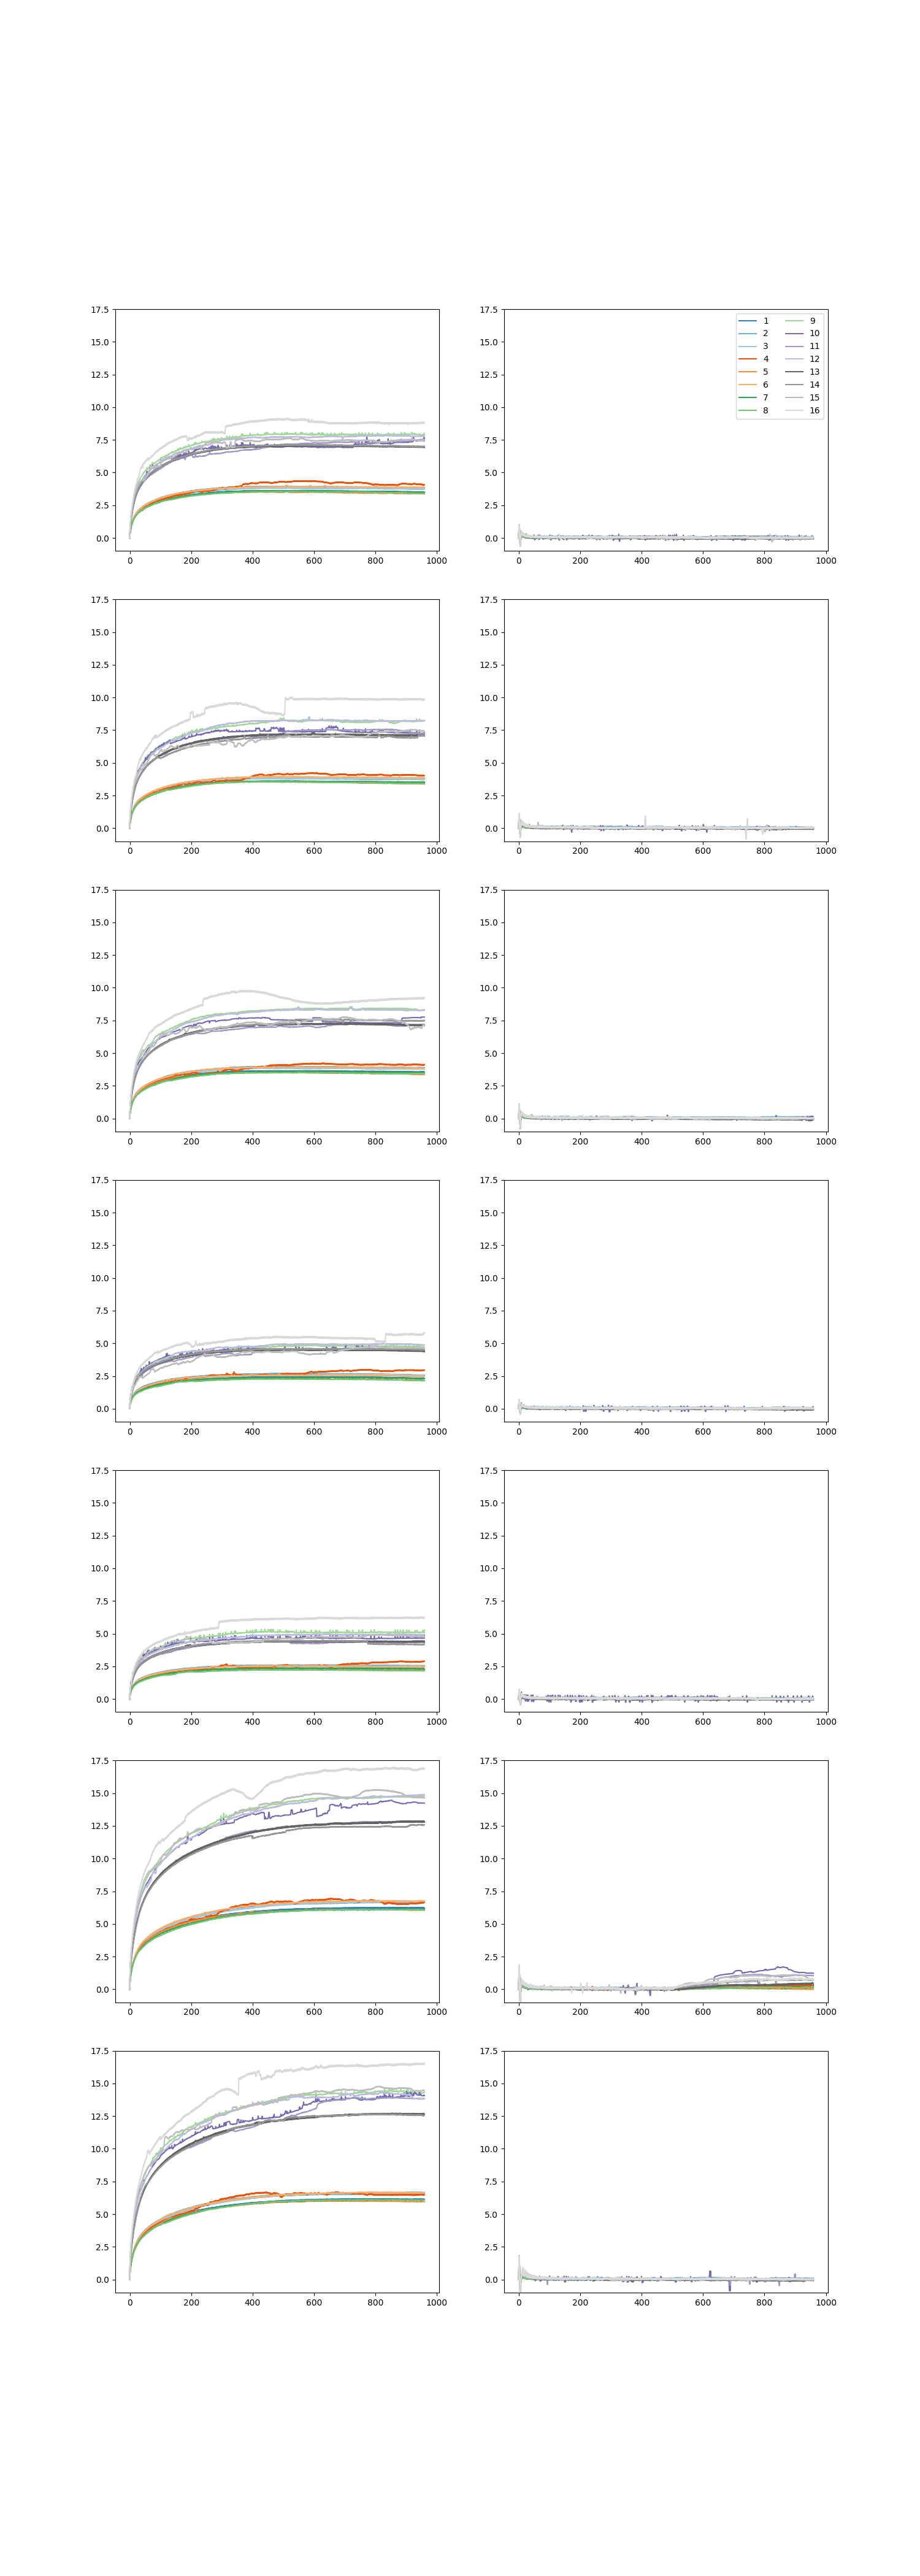

In [9]:
print(len(frwd))
print(frwd[0][1].shape)
plt.rcParams['svg.fonttype'] = 'none' # to embed fonts in SVG output

files  = ['meas_MID00503_FID66386_aa_bss_TR40ms_Dur8ms_FA600_Rep10_Corr0_Tra',
          'meas_MID00504_FID66387_aa_bss_TR40ms_Dur8ms_FA600_Rep10_Corr1_Tra',
          'meas_MID00492_FID66375_aa_bss_TR40ms_Dur8ms_FA400_Rep10_Corr0_Tra',
          'meas_MID00493_FID66376_aa_bss_TR40ms_Dur8ms_FA400_Rep10_Corr1_Tra',
          'meas_MID00488_FID66371_aa_bss_TR40ms_Dur8ms_FA250_Rep10_Corr0_Tra',
          'meas_MID00489_FID66372_aa_bss_TR40ms_Dur8ms_FA250_Rep10_Corr1_Tra',
          'meas_MID00501_FID66384_aa_bss_TR40ms_Dur5ms_FA400_Rep10_Corr0_Tra',
          'meas_MID00502_FID66385_aa_bss_TR40ms_Dur5ms_FA400_Rep10_Corr1_Tra',
          'meas_MID00496_FID66379_aa_bss_TR40ms_Dur5ms_FA250_Rep10_Corr0_Tra',
          'meas_MID00497_FID66380_aa_bss_TR40ms_Dur5ms_FA250_Rep10_Corr1_Tra',
          'meas_MID00484_FID66367_aa_bss_TR25ms_Dur8ms_FA250_Rep15_Corr0_Tra',
          'meas_MID00486_FID66369_aa_bss_TR25ms_Dur8ms_FA250_Rep10_Corr1_Tra',          
          'meas_MID00499_FID66382_aa_bss_TR25ms_Dur8ms_FA400_Rep10_Corr0_Tra',
          'meas_MID00500_FID66383_aa_bss_TR25ms_Dur8ms_FA400_Rep10_Corr1_Tra'          
          ]

RF_ind = 1
plt.close('all')

fig, ax = plt.subplots(len(files)//2, 2, figsize=(15, 6*len(files)//2))
for ind, frw in enumerate(frwd):
    frw_temp = 100 * (frw[RF_ind]/frw[RF_ind][:,[0]] -1)
    ax[ind//2, ind%2].set_prop_cycle(plt.cycler('color', plt.cm.tab20c(np.linspace(0, 1, frw[RF_ind].shape[0]))))
    ax[ind//2, ind%2].plot(frw_temp.T)
    ax[ind//2, ind%2].set_ylim([-1, 17.5]) # phantom
    if ind == 1:
        ax[ind//2, ind%2].legend(list(range(1, 17)), bbox_to_anchor=(0, 0, 1, 1), ncol=2)

    print(f'Max drift: {100 * (frw[0][:,-1]/frw[0][:,0] - 1)}')

# plt.savefig('/DATA/aaghaeifar/Nextcloud/MyPresentations/ismrm2024/figures/drifts.svg', format='svg', dpi=1200)